# Thesis: Alphafold3 Prediction Analysis
---

In [159]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

In [160]:
# Read in data
df = pd.read_csv('../data/af3_data.csv')
hal_df = pd.read_csv('../data/hal_data.csv')

# Create SMILES dataframe with SMILES columns
smiles_cols = [col for col in df.columns if 'SMILES' in col]
smiles_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + smiles_cols]

# Create CCD dataframe with CCD columns 
ccd_cols = [col for col in df.columns if 'CCD' in col]
ccd_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + ccd_cols]

In [161]:
smiles_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES RMSD,SMILES DOCKQ SCORE,SMILES DOCKQ iRMSD,SMILES DOCKQ LRMSD,SMILES FRACTION DISORDERED,SMILES HAS_CLASH,SMILES IPTM,SMILES PTM,SMILES RANKING_SCORE
0,5HXB,2016-06-29,0.683,0.874,0.785,1.411,0.03,0,0.86,0.84,0.87
1,5T35,2017-03-08,2.350,0.578,1.736,5.485,0.10,0,0.75,0.82,0.81
2,6BN7,2018-05-30,0.601,0.226,4.539,12.923,0.06,0,0.85,0.85,0.88
3,6BOY,2018-05-30,0.765,0.092,6.875,18.065,0.16,0,0.60,0.66,0.69
4,6HM0,2019-01-16,0.317,NaN,NaN,NaN,0.09,0,0.87,0.88,0.92


In [162]:
ccd_df.head()

,PDB_ID,PDB_RELEASE_DATE,CCD RMSD,CCD DOCKQ SCORE,CCD DOCKQ iRMSD,CCD DOCKQ LRMSD,CCD FRACTION DISORDERED,CCD HAS_CLASH,CCD IPTM,CCD PTM,CCD RANKING_SCORE
0,5HXB,2016-06-29,0.674,0.867,0.783,1.286,0.03,0,0.87,0.84,0.88
1,5T35,2017-03-08,2.000,0.629,1.471,4.559,0.09,0,0.72,0.79,0.78
2,6BN7,2018-05-30,0.716,0.674,1.134,3.446,0.06,0,0.85,86.00,0.88
3,6BOY,2018-05-30,0.643,0.426,2.259,7.594,0.12,0,0.64,0.70,0.72
4,6HM0,2019-01-16,0.397,NaN,NaN,NaN,0.08,0,0.88,0.88,0.92


In [163]:
hal_df.head()

,PDB_ID,PDB_LINK,PDB_RELEASE_DATE,AF3_DIMERS DOCKQ SCORE,AF3_DIMERS iRMSD,AF3_DIMERS LRMSD,AF3_CONTEXT DOCKQ SCORE,AF3_CONTEXT iRMSD,AF3_CONTEXT LRMSD
0,5HXB,5HXB,2016-06-29,0.840,0.848,2.165,0.027,12.608,42.404
1,5T35,5T35,2017-03-08,0.014,12.765,49.502,0.019,16.143,37.396
2,6BOY,6BOY,2018-05-30,0.020,11.618,40.270,0.021,11.201,38.396
3,6HAX,6HAX,2019-06-12,0.019,10.682,43.182,0.050,9.364,22.506
4,6HAY,6HAY,2019-06-12,0.058,10.153,26.116,0.055,8.603,21.415


## Plot PBDID vs DockQ Scores

---

In [164]:
smiles_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ SCORE']].copy()
ccd_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ SCORE']].copy()
smiles_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES RMSD']].copy()
ccd_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD RMSD']].copy()
smiles_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ LRMSD']].copy()
ccd_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ LRMSD']].copy()

# Drop rows with missing DockQ scores from both dataframes
smiles_dockq_df = smiles_dockq_df.dropna(subset=['SMILES DOCKQ SCORE'])
ccd_dockq_df = ccd_dockq_df.dropna(subset=['CCD DOCKQ SCORE'])
smiles_lrmsd_df = smiles_lrmsd_df.dropna(subset=['SMILES DOCKQ LRMSD'])
ccd_lrmsd_df = ccd_lrmsd_df.dropna(subset=['CCD DOCKQ LRMSD'])

# Create RMSD dataframes without conversion (will be handled in plot_scores)
smiles_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES RMSD']]
ccd_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD RMSD']]

smiles_dockq_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES DOCKQ SCORE
0,5HXB,2016-06-29,0.874
1,5T35,2017-03-08,0.578
2,6BN7,2018-05-30,0.226
3,6BOY,2018-05-30,0.092
5,6HAY,2019-06-12,0.352


In [165]:
def plot_scores_combined(smiles_df, ccd_df, 
                         smiles_score_col='SMILES DOCKQ SCORE', 
                         ccd_score_col='CCD DOCKQ SCORE', 
                         title=None, 
                         y_axis_label="DockQ Score", 
                         add_threshold=False, 
                         threshold_value=0.23, 
                         save=False):
    """
    Create a combined scatter plot for SMILES and CCD scores (DockQ, RMSD, etc.).
    
    Parameters:
    -----------
    smiles_df : pandas.DataFrame
        DataFrame containing 'PDB_ID', 'PDB_RELEASE_DATE', and the column for SMILES score.
    ccd_df : pandas.DataFrame
        DataFrame containing 'PDB_ID', 'PDB_RELEASE_DATE', and the column for CCD score.
    smiles_score_col : str, optional
        Name of the column in smiles_df to use for scoring 
        (default: 'SMILES DOCKQ SCORE').
    ccd_score_col : str, optional
        Name of the column in ccd_df to use for scoring 
        (default: 'CCD DOCKQ SCORE').
    title : str, optional
        Title for the plot (defaults to "Comparison of AlphaFold3 PROTAC Structure Predictions with Experimental Data").
    y_axis_label : str, optional
        Label for the y-axis (defaults to "DockQ Score").
    add_threshold : bool, optional
        Whether to add a horizontal threshold line (default: False).
    threshold_value : float, optional
        Y-value for the threshold line (default: 0.23).
    save : bool, optional
        Whether to save the plot to ../data/plots (default: True).
    """
    # Merge the two dataframes on 'PDB_ID' and 'PDB_RELEASE_DATE'
    combined_df = pd.merge(smiles_df, ccd_df, on=['PDB_ID', 'PDB_RELEASE_DATE'], how='outer')
    combined_df = combined_df.sort_values('PDB_RELEASE_DATE').reset_index(drop=True)
    
    # Set up x-axis positions (one position per PDB)
    n = len(combined_df)
    x = np.arange(n)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date.
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(combined_df['PDB_ID'], combined_df['PDB_RELEASE_DATE'])
    ]
    
    # Set a default title if none is provided.
    if title is None:
        title = "Comparison of AlphaFold3 PROTAC Structure Predictions with Experimental Data"
    
    # Create the plot.
    plt.style.use('default')
    plt.figure(figsize=(15, 8))
    
    # Plot the SMILES scores.
    scatter_smiles = plt.scatter(
        x, combined_df[smiles_score_col], 
        color='#003366', marker='o', s=80, edgecolor='black', linewidth=0.5,
        label='LIGAND SMILES'
    )
    
    # Plot the CCD scores.
    scatter_ccd = plt.scatter(
        x, combined_df[ccd_score_col], 
        color='#DC143C', marker='o', s=80, edgecolor='black', linewidth=0.5,
        label='LIGAND CCD'
    )

    # Add a horizontal threshold line if requested.
    threshold_handle = None
    if add_threshold:
        threshold_handle = plt.axhline(
            y=threshold_value, color='black', linestyle='--', alpha=0.3, linewidth=1,
            label=f'Acceptable Threshold ({threshold_value})'
        )
    
    # Set custom x-axis labels using the PDB ID labels.
    plt.xticks(x, pdb_labels, rotation=45, ha='center')
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.ylabel(y_axis_label, fontsize=14, fontweight='bold')
    plt.xlabel('PDB Identifier', fontsize=14, fontweight='bold')
    plt.ylim(0.0)
    plt.grid(True, linestyle='--', alpha=0.3, which='major')
    
    # Add an annotation to explain the asterisk (*) notation.
    plt.figtext(
        0.99, 0.01, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
        ha='right', fontsize=8, style='italic'
    )
    
    # Set custom legend order: CCD, SMILES, then threshold (if added).
    handles = [scatter_ccd, scatter_smiles]
    if add_threshold:
        handles.append(threshold_handle)
    plt.legend(handles=handles, title_fontsize=12, fontsize=10,
               loc='upper right', framealpha=0.7, edgecolor='black')

    plt.tight_layout()
    
    # Save the plot if required.
    if save:
        filename = title.lower().replace(' ', '_')
        filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
        save_path = '../data/plots'
        plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

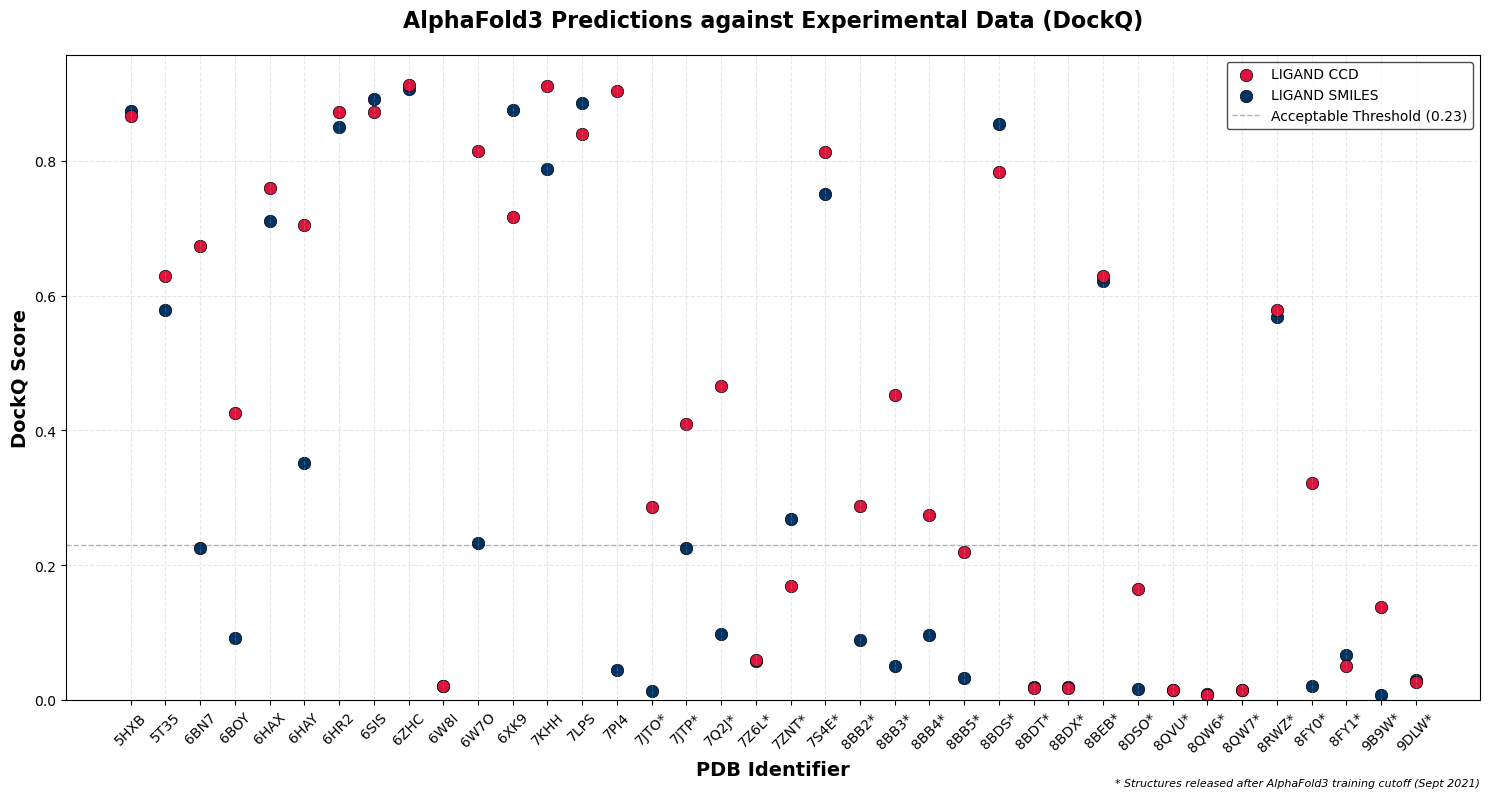

In [166]:
plot_scores_combined(
       smiles_df=smiles_dockq_df, 
       ccd_df=ccd_dockq_df, 
       title="AlphaFold3 Predictions against Experimental Data (DockQ)", 
       add_threshold=True,
       save=True
   )

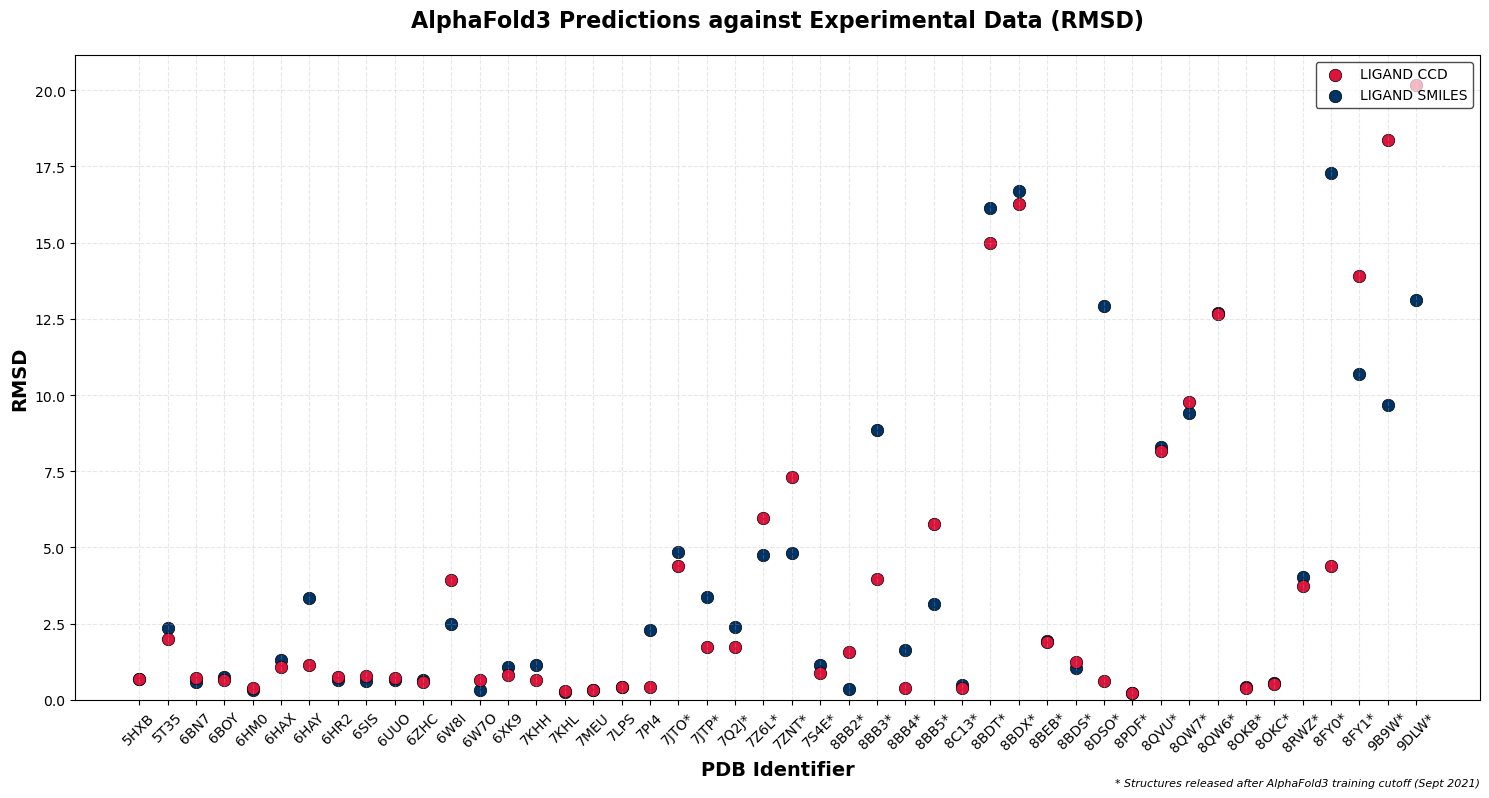

In [167]:
plot_scores_combined(
       smiles_df=smiles_rmsd_df, 
       ccd_df=ccd_rmsd_df,
       smiles_score_col='SMILES RMSD',
       ccd_score_col='CCD RMSD',
       title="AlphaFold3 Predictions against Experimental Data (RMSD)",
       y_axis_label="RMSD",
       add_threshold=False,
       threshold_value=4,
       save=True
   )

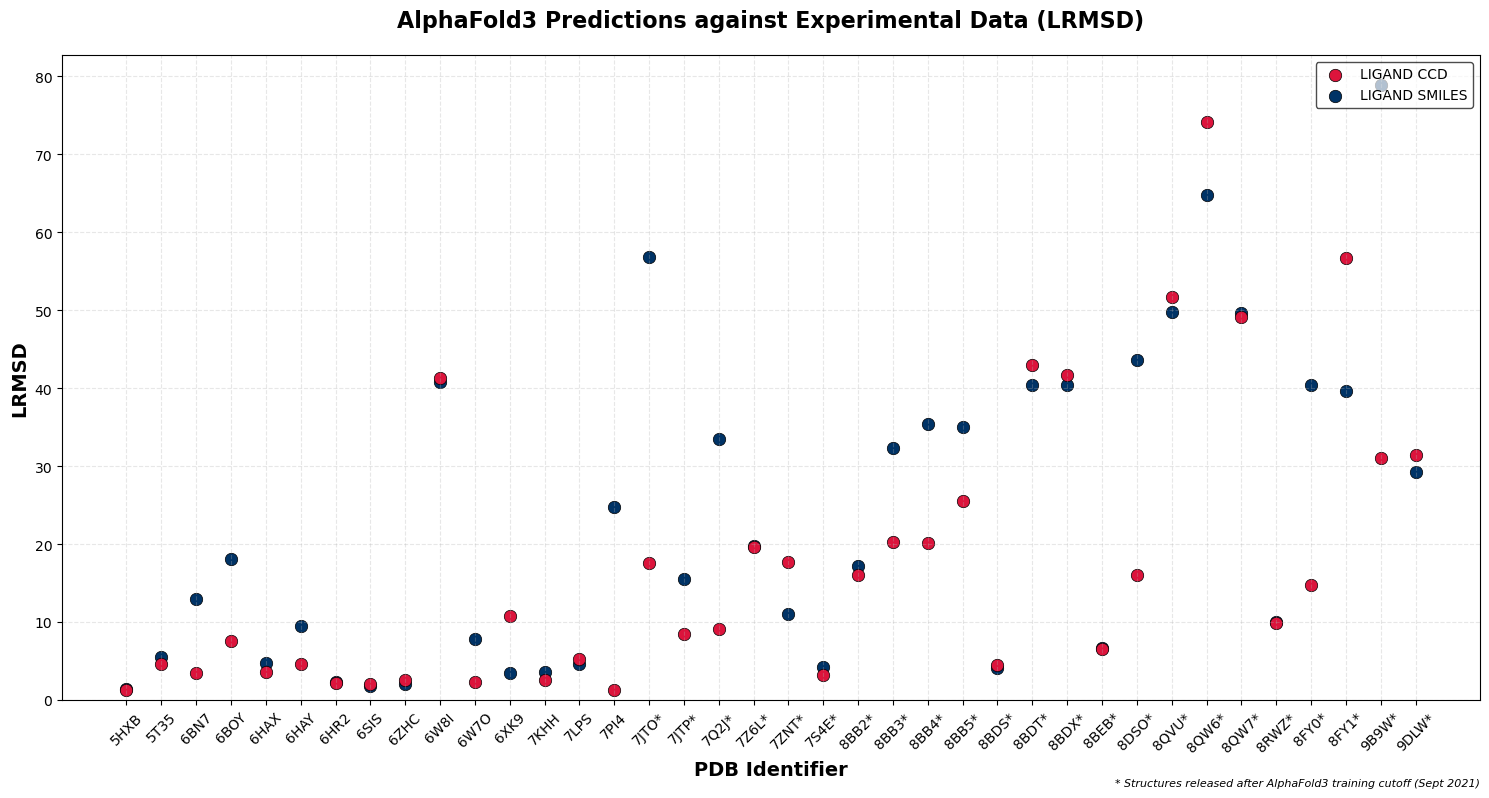

In [168]:
plot_scores_combined(
       smiles_df=smiles_lrmsd_df, 
       ccd_df=ccd_lrmsd_df,
       smiles_score_col='SMILES DOCKQ LRMSD',
       ccd_score_col='CCD DOCKQ LRMSD',
       title="AlphaFold3 Predictions against Experimental Data (LRMSD)",
       y_axis_label="LRMSD",
       add_threshold=False,
       save=True
   )

## HAL Paper Results Comparasion

---

In [169]:
comparison_df = hal_df[['PDB_ID', 'PDB_RELEASE_DATE', 'AF3_DIMERS DOCKQ SCORE', 'AF3_DIMERS iRMSD', 'AF3_DIMERS LRMSD', 'AF3_CONTEXT DOCKQ SCORE', 'AF3_CONTEXT iRMSD', 'AF3_CONTEXT LRMSD']].copy()

# Merge CCD data
ccd_columns = ['PDB_ID', 'CCD DOCKQ SCORE', 'CCD DOCKQ iRMSD ', 'CCD DOCKQ LRMSD']
comparison_df = comparison_df.merge(df[ccd_columns], on='PDB_ID', how='left')

# Merge SMILES data
smiles_columns = ['PDB_ID', 'SMILES DOCKQ SCORE', 'SMILES DOCKQ iRMSD', 'SMILES DOCKQ LRMSD']
comparison_df = comparison_df.merge(df[smiles_columns], on='PDB_ID', how='left')

# Sort by release date (oldest to newest)
comparison_df = comparison_df.sort_values('PDB_RELEASE_DATE', ascending=True)

comparison_df.head()

,PDB_ID,PDB_RELEASE_DATE,AF3_DIMERS DOCKQ SCORE,AF3_DIMERS iRMSD,AF3_DIMERS LRMSD,AF3_CONTEXT DOCKQ SCORE,AF3_CONTEXT iRMSD,AF3_CONTEXT LRMSD,CCD DOCKQ SCORE,CCD DOCKQ iRMSD,CCD DOCKQ LRMSD,SMILES DOCKQ SCORE,SMILES DOCKQ iRMSD,SMILES DOCKQ LRMSD
0,5HXB,2016-06-29,0.840,0.848,2.165,0.027,12.608,42.404,0.867,0.783,1.286,0.874,0.785,1.411
1,5T35,2017-03-08,0.014,12.765,49.502,0.019,16.143,37.396,0.629,1.471,4.559,0.578,1.736,5.485
2,6BOY,2018-05-30,0.020,11.618,40.270,0.021,11.201,38.396,0.426,2.259,7.594,0.092,6.875,18.065
6,6BN7,2018-05-30,0.022,10.621,38.038,0.023,10.639,37.781,0.674,1.134,3.446,0.226,4.539,12.923
3,6HAX,2019-06-12,0.019,10.682,43.182,0.050,9.364,22.506,0.760,0.829,3.601,0.711,0.982,4.674


In [170]:
def plot_dockq_comparison(comparison_df, title="AlphaFold3 Predictions against Experimental Data", save=False):
    """
    Create a scatter plot comparing DockQ scores between different methods.
    """
    # Use scientific style
    plt.style.use('default')  # Reset to default style first
    
    # Create figure with higher DPI for better quality
    plt.figure(figsize=(15, 8), dpi=300)
    
    # Define professional color scheme (colorblind-friendly)
    methods = {
        'LIGAND CCD': ('CCD DOCKQ SCORE', '#DC143C', 'o'), 
        'LIGAND SMILES': ('SMILES DOCKQ SCORE', '#003366', 'o'),
        'NO LIGAND': ('AF3_DIMERS DOCKQ SCORE', '#A9A9A9', 'o')
    }
    
    for label, (column, color, marker) in methods.items():
        plt.scatter(range(len(comparison_df)), comparison_df[column], 
                   color=color, label=label, s=80, 
                   marker=marker, edgecolors='black', linewidth=0.5)
    
    # Add threshold line with label
    plt.axhline(y=0.23, color='black', linestyle='--', alpha=0.3, linewidth=1,
                label='Acceptable Threshold (0.23)')
    
    # Create PDB ID labels
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
                 for pdb, date in zip(comparison_df['PDB_ID'], comparison_df['PDB_RELEASE_DATE'])]
    
    # Improve title and labels with clear, descriptive text
    plt.title(title, 
              fontsize=16, pad=20, fontweight='bold')
    plt.ylabel('DockQ Score', fontsize=14, fontweight='bold')
    plt.xlabel('PDB Identifier', fontsize=14, fontweight='bold')
    
    # Set axis limits and ticks
    plt.ylim(0.0, 1.0)  # Slightly extend y-axis for better visualization
    plt.xlim(-0.5, len(comparison_df) - 0.5)  # Adjust x-axis limits
    
    # Format tick labels
    plt.xticks(range(len(comparison_df)), pdb_labels, 
               rotation=45, ha='center', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3, which='major')
    
    # Improve legend
    plt.legend(
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        framealpha=0.7,
        edgecolor='black'
    )
    
    # Add annotation for the dagger symbol
    plt.figtext(0.99, 0.01, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
                ha='right', fontsize=8, style='italic')
    
    # Add spines
    ax = plt.gca()
    ax.spines['top'].set_visible(0.5)
    ax.spines['right'].set_visible(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if required.
    if save:
        filename = title.lower().replace(' ', '_')
        filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
        save_path = '../data/plots'
        plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')


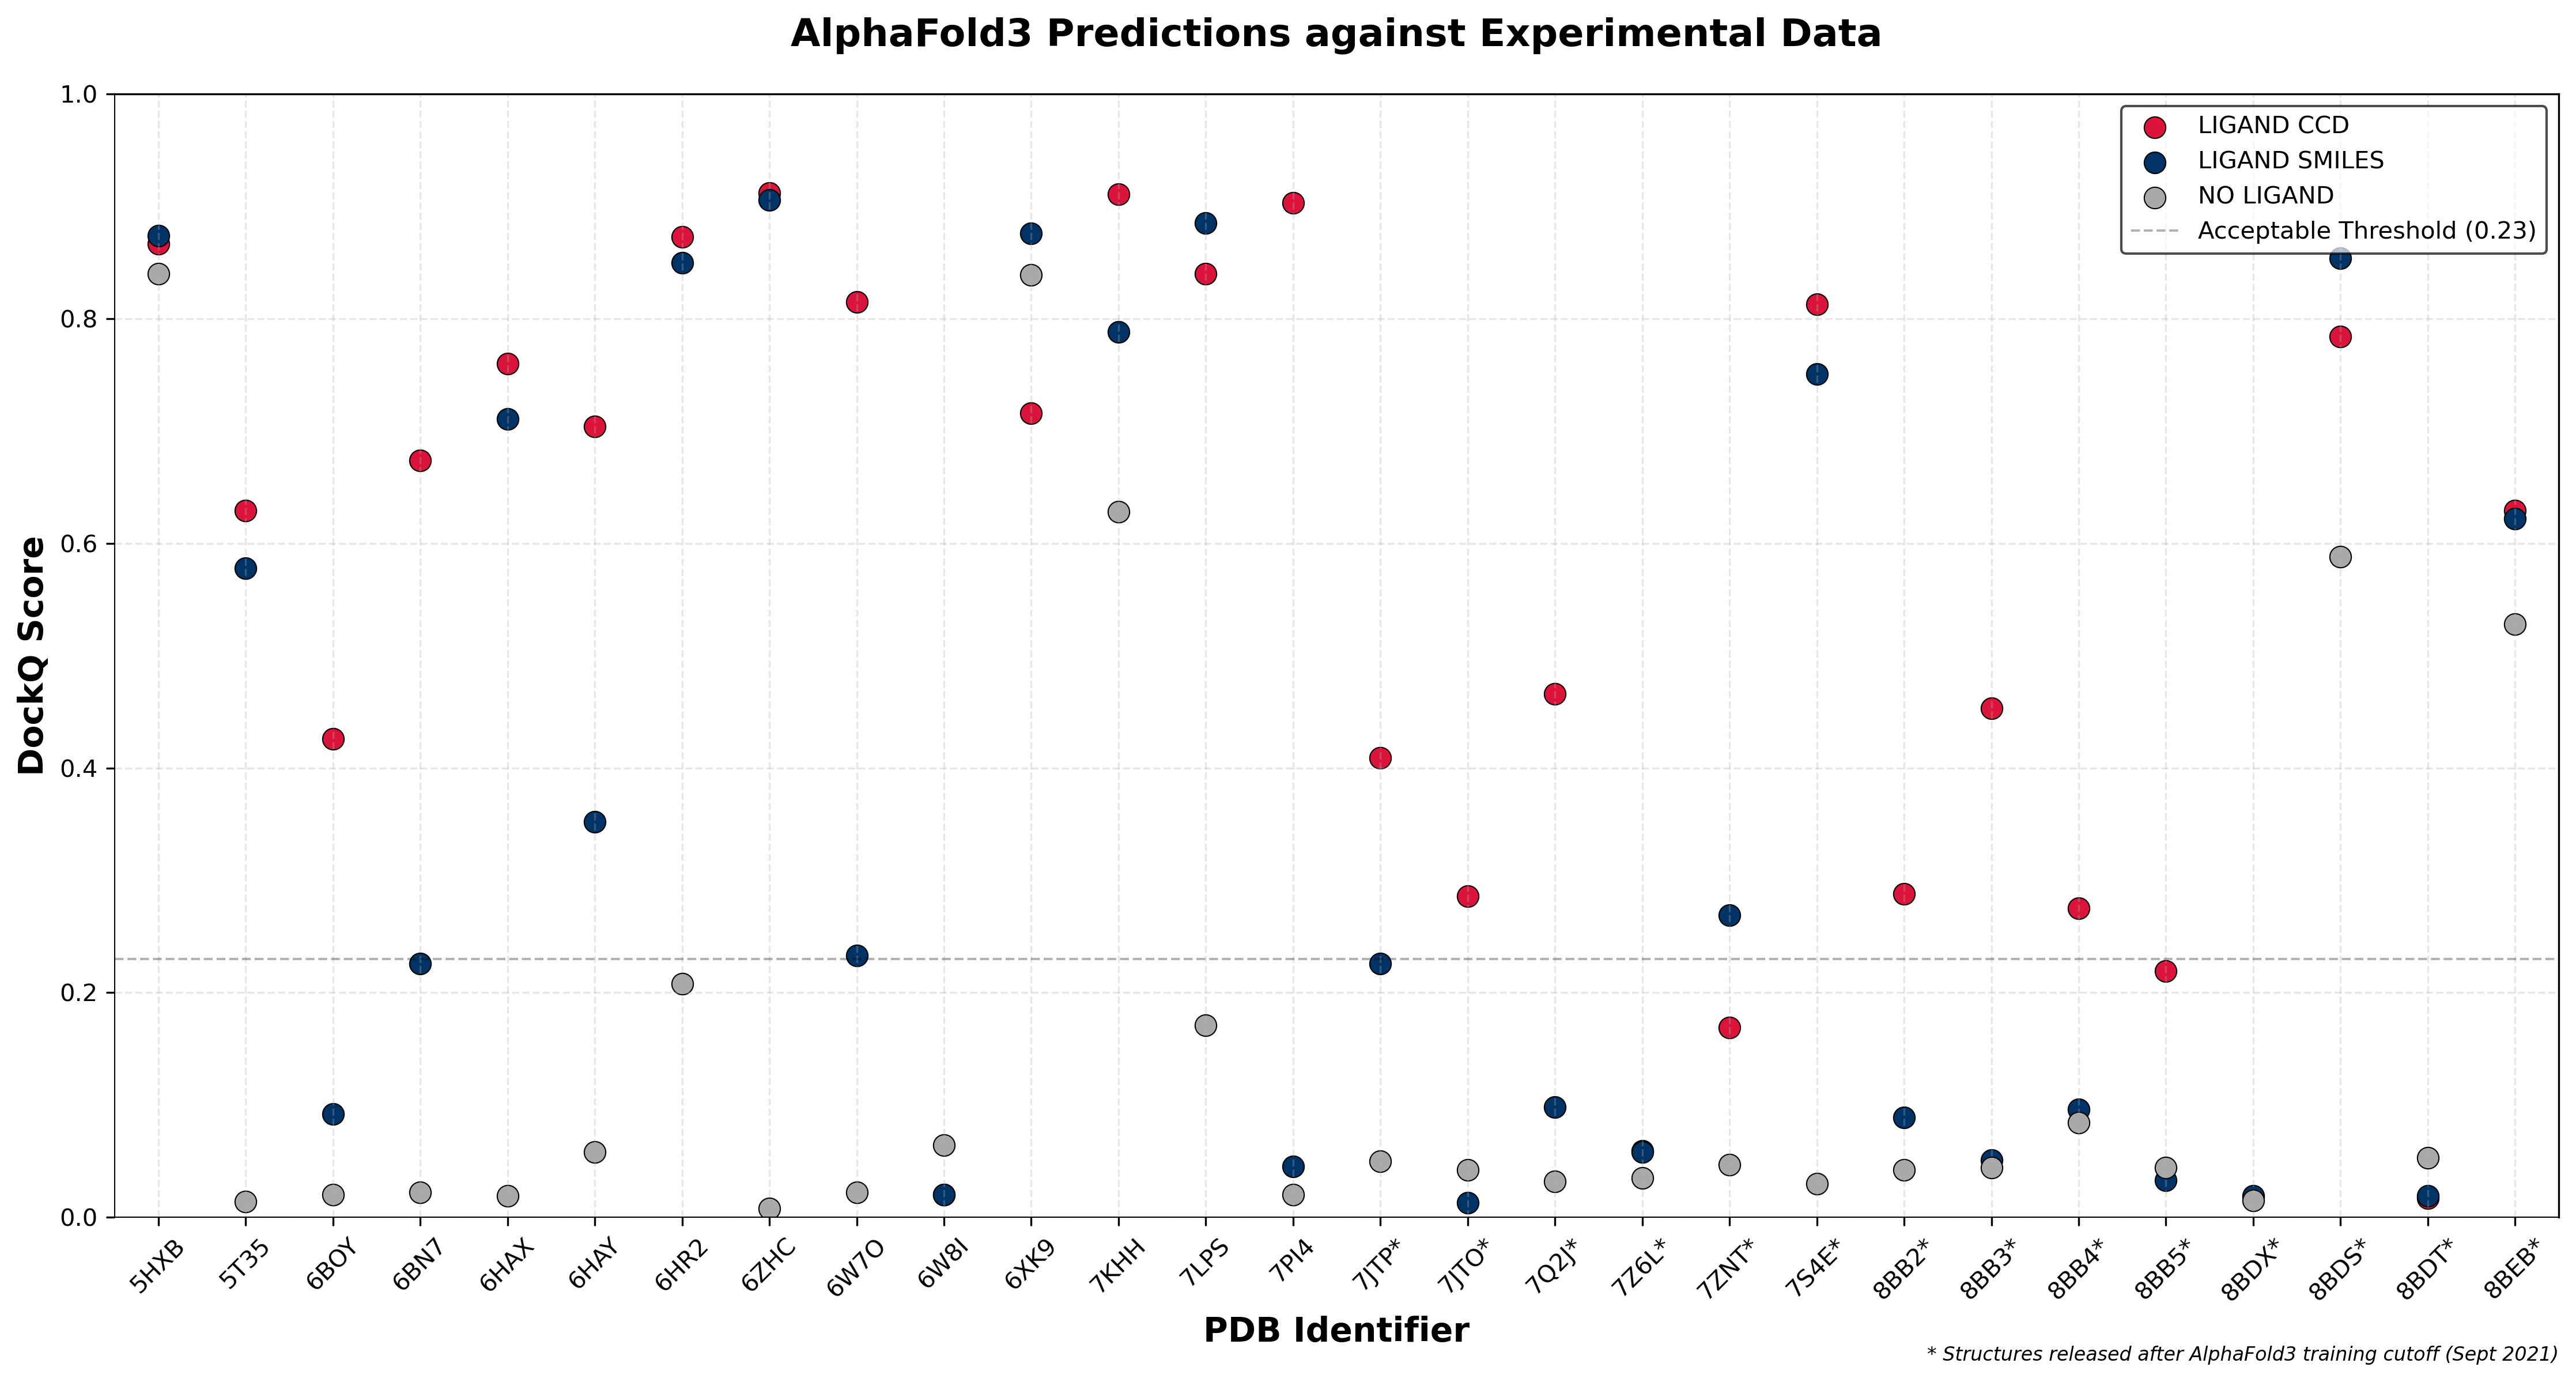

In [171]:
plot_dockq_comparison(comparison_df, save=True)

## Spearman Rank Correlations

---

In [172]:
def calculate_spearman_correlations(df):
    """
    Calculate Spearman rank correlations between specified pairs of variables.
    Returns both correlation coefficients and p-values.
    """
    # Define pairs to compare
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs iPTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs iPTM'),
        ('SMILES DOCKQ SCORE', 'SMILES RMSD', 'SMILES DockQ vs RMSD'),
        ('CCD DOCKQ SCORE', 'CCD RMSD', 'CCD DockQ vs RMSD')
    ]
    
    results = []
    
    for var1, var2, label in pairs:
        # Remove rows with NaN values for this pair
        pair_df = df[[var1, var2]].dropna()
        
        # Calculate Spearman correlation
        correlation, p_value = stats.spearmanr(pair_df[var1], pair_df[var2])
        
        # Store results
        results.append({
            'Comparison': label,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': len(pair_df)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Format the results
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['P-value'] = results_df['P-value'].round(4)
    
    return results_df

In [173]:
correlation_results = calculate_spearman_correlations(df)

# Display results in a nicely formatted table
print("\nSpearman Rank Correlations:")
print("============================")
print(correlation_results.to_string(index=False))


Spearman Rank Correlations:
          Comparison  Correlation  P-value  Sample Size
 SMILES DockQ vs PTM        0.551   0.0003           38
    CCD DockQ vs PTM        0.621   0.0000           38
SMILES DockQ vs iPTM        0.626   0.0000           38
   CCD DockQ vs iPTM        0.740   0.0000           38
SMILES DockQ vs RMSD       -0.755   0.0000           38
   CCD DockQ vs RMSD       -0.775   0.0000           38


In [174]:
def plot_correlation_pairs(df):
    """
    Create scatter plots for each correlation pair.
    """
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs iPTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs iPTM'),
        ('SMILES DOCKQ SCORE', 'SMILES RMSD', 'SMILES DockQ vs RMSD'),
        ('CCD DOCKQ SCORE', 'CCD RMSD', 'CCD DockQ vs RMSD')
    ]
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes = axes.ravel()
    
    for idx, (var1, var2, title) in enumerate(pairs):
        # Get data without NaN values
        plot_df = df[[var1, var2]].dropna()
        
        # Calculate correlation
        corr, _ = stats.spearmanr(plot_df[var1], plot_df[var2])
        
        # Create scatter plot
        axes[idx].scatter(plot_df[var1], plot_df[var2], alpha=0.6, color='#003366')
        axes[idx].set_xlabel(var1)
        axes[idx].set_ylabel(var2)
        axes[idx].set_title(f'{title}\nρ = {corr:.3f}')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

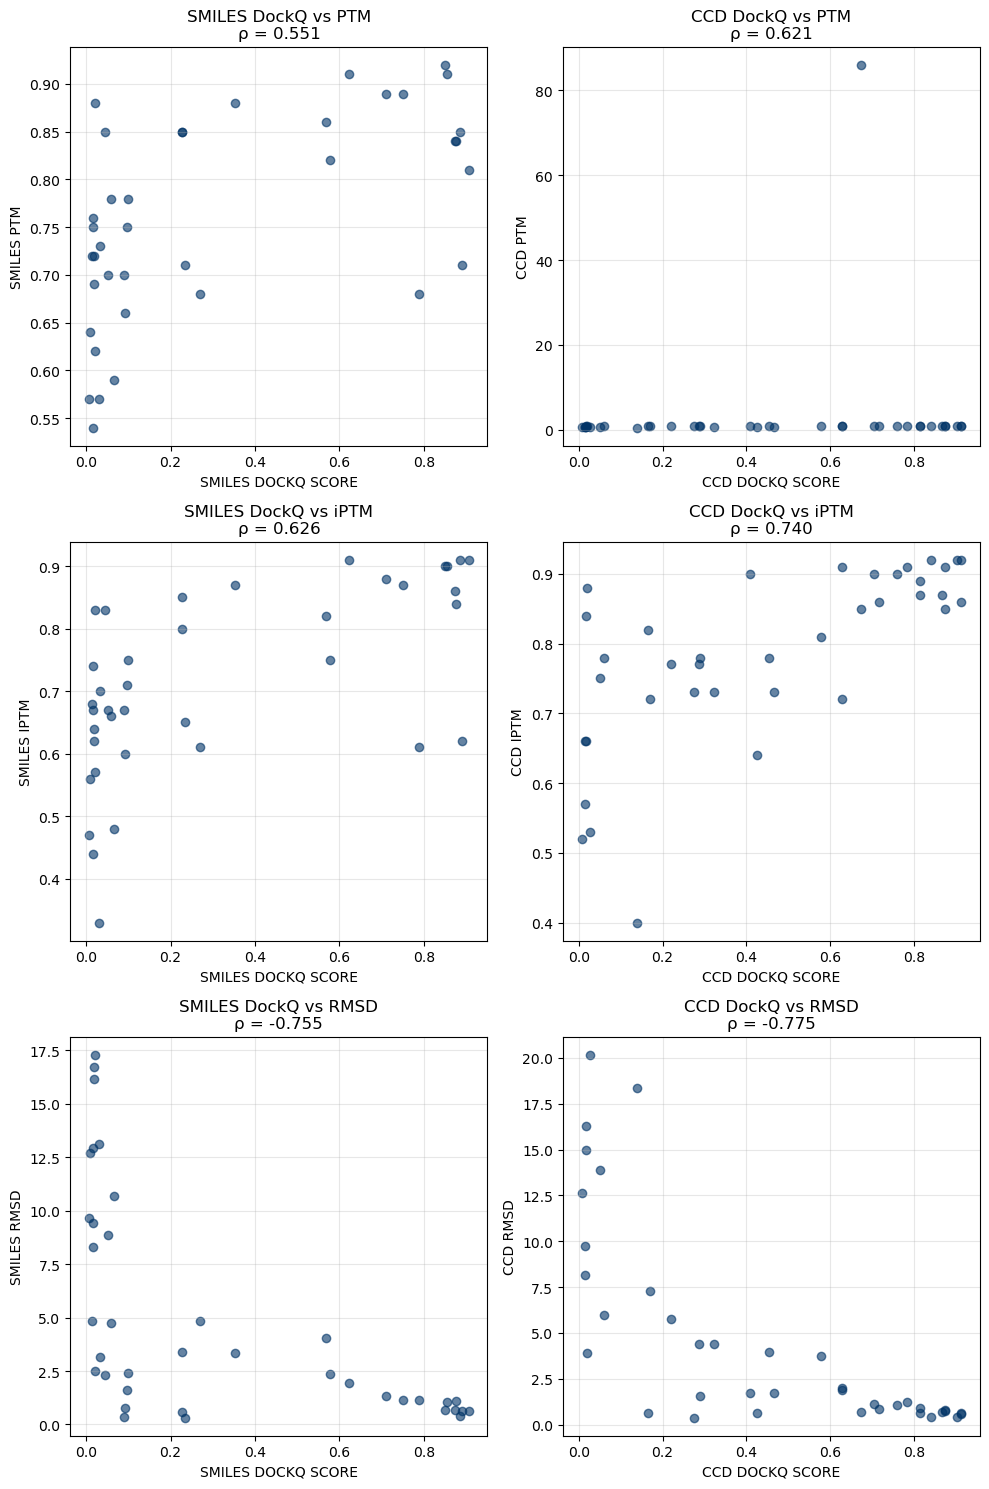

In [175]:
plot_correlation_pairs(df)